# train

In [1]:
import yaml
import os

with open("./config.yaml", 'rb') as f:
    config = yaml.load(f)

<ipython-input-1-1499ab5789c7>:5: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  config = yaml.load(f)


In [2]:
OUTPUT_ROOT = config['IO_OPTION']['OUTPUT_ROOT']
os.makedirs(OUTPUT_ROOT, exist_ok=True)

## load library

In [3]:
# python default library
import os
import shutil
import datetime
import sys
import pickle

# general analysis tool-kit
import numpy as np
import pandas as pd
#from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import seaborn as sns

# pytorch
import torch
from torch import optim, nn
from torch.utils.tensorboard import SummaryWriter

#from torchsummary import summary

# etc
import yaml
yaml.warnings({'YAMLLoadWarning': False})

# original library
sys.path.append('/home/hiroki/research/dcase2021_task2/src/functions')
import common as com
import pytorch_modeler as modeler
from pytorch_model import Conditional_VAE as Model
#from pytorch_utils import filtered_load_model
#import models

import librosa
import IPython
import librosa.display

## load config and set logger

In [4]:
log_file = config['IO_OPTION']['OUTPUT_ROOT']+'/train_{0}.log'.format(datetime.date.today())
logger = com.setup_logger(log_file, '00_train.py')

## Setting

In [5]:
# Setting seed
modeler.set_seed(777)

In [6]:
############################################################################
# Setting I/O path
############################################################################
# input dirs
INPUT_ROOT = config['IO_OPTION']['INPUT_ROOT']
#dev_dir = INPUT_ROOT + "/dev_data"
#add_dev_dir = INPUT_ROOT + "/add_dev_data"
# machine type
machine_types = ['ToyCar', 'gearbox', 'valve', 'ToyTrain', 'pump', 'fan', 'slider']
# output dirs
OUTPUT_ROOT = config['IO_OPTION']['OUTPUT_ROOT']
MODEL_DIR = config['IO_OPTION']['OUTPUT_ROOT'] + '/models'
TB_DIR = config['IO_OPTION']['OUTPUT_ROOT'] + '/tb'
OUT_FEATURE_DIR = OUTPUT_ROOT + '/extraction_features'
OUT_SCORE_DIR = OUTPUT_ROOT + '/score'
OUT_PRED_DIR = OUTPUT_ROOT + '/pred'
#os.makedirs(OUTPUT_ROOT, exist_ok=True)
os.makedirs(MODEL_DIR, exist_ok=True)
os.makedirs(TB_DIR, exist_ok=True)
os.makedirs(OUT_FEATURE_DIR, exist_ok=True)
os.makedirs(OUT_SCORE_DIR, exist_ok=True)
os.makedirs(OUT_PRED_DIR, exist_ok=True)
# copy config
shutil.copy('./config.yaml', OUTPUT_ROOT)

'/media/hiroki/HDD1TB/research/dcase2021_task2/output/CenterLossVAE/ex6/config.yaml'

In [7]:
torch.cuda.is_available()

True

In [8]:
ext_data = pd.read_pickle(f'{INPUT_ROOT}/valve_features.pkl')

In [9]:
pd.DataFrame(ext_data['train']['features'])

,0,1,2,3,4,5,6,7,8,9,...,3766,3767,3768,3769,3770,3771,3772,3773,3774,3775
0,0.243716,0.338328,0.272088,0.226127,0.029367,0.339973,0.209255,0.105823,0.137297,0.145012,...,0.022174,0.006773,0.069666,0.301964,0.180498,0.033291,0.098398,0.024299,0.016897,0.123153
1,0.237665,0.327515,0.263212,0.232293,0.027842,0.367579,0.210006,0.094775,0.134482,0.143913,...,0.027657,0.028354,0.165744,0.330388,0.136494,0.035396,0.146613,0.123391,0.007483,0.144597
2,0.225514,0.379070,0.276066,0.196089,0.027455,0.265828,0.224954,0.132161,0.143215,0.143278,...,0.040949,0.034133,0.122343,0.213779,0.166338,0.049096,0.042672,0.044685,0.002102,0.145841
3,0.241087,0.328841,0.287649,0.230211,0.029166,0.339409,0.215851,0.104063,0.135149,0.140004,...,0.047530,0.000834,0.029579,0.157189,0.159237,0.092072,0.176285,0.072260,0.025339,0.222447
4,0.247998,0.328309,0.278905,0.237095,0.027144,0.362545,0.209568,0.100579,0.133083,0.137760,...,0.022089,0.001686,0.082939,0.303310,0.165293,0.078591,0.169059,0.093608,0.015137,0.118250
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6013,0.242294,0.320149,0.291148,0.246376,0.024519,0.336719,0.213888,0.098774,0.152700,0.135828,...,0.028749,0.020032,0.089271,0.324535,0.164114,0.011856,0.131130,0.048871,0.016199,0.125525
6014,0.239820,0.328761,0.283221,0.232255,0.026091,0.329097,0.217799,0.107723,0.151887,0.142054,...,0.065597,0.009168,0.159468,0.321171,0.235521,0.020378,0.059581,0.037248,0.034675,0.046954
6015,0.233884,0.312639,0.287863,0.243157,0.024677,0.309460,0.243808,0.103488,0.180332,0.135159,...,0.159631,0.007203,0.071548,0.284185,0.112961,0.240836,0.032650,0.014332,0.023457,0.157205
6016,0.232720,0.344319,0.275893,0.233720,0.027888,0.292808,0.227276,0.124664,0.170116,0.145821,...,0.098789,0.002348,0.054095,0.253814,0.089476,0.159530,0.034791,0.019259,0.031108,0.169736


## training

In [10]:
#############################################################################
# run
#############################################################################
def run(machine_type):
    com.tic()
    
    logger.info('TARGET MACHINE_TYPE: {0}'.format(machine_type))
    logger.info('MAKE DATA_LOADER')
    # dataloader
    ext_data = pd.read_pickle(f'{INPUT_ROOT}/{machine_type}_features.pkl')
    dataloaders_dict = modeler.make_dataloader(ext_data)
    # define writer for tensorbord
    os.makedirs(TB_DIR+'/'+machine_type, exist_ok=True)
    tb_log_dir = TB_DIR + '/' + machine_type
    writer = SummaryWriter(log_dir = tb_log_dir)
    # out path
    model_out_path = MODEL_DIR+'/{}_model.pth'.format(machine_type)
    score_out_path = OUT_SCORE_DIR + '/{}_score.csv'.format(machine_type)
    pred_out_path = OUT_PRED_DIR + '/{}_pred.csv'.format(machine_type)
    logger.info('TRAINING')
    # parameter setting
    in_features = ext_data['train']['features'].shape[1]
    mid_size = config['param']['mid_size']
    latent_size = config['param']['latent_size']
    num_classes = 6
    net = Model(in_features, mid_size, latent_size, num_classes)
    optimizer = optim.Adam(net.parameters(), lr=1e-3)
    num_epochs = config['param']['num_epochs']
    #scheduler = optim.lr_scheduler.OneCycleLR(optimizer=optimizer, pct_start=0.1, div_factor=1e-2, 
    #                                          max_lr=1e-3, epochs=num_epochs, steps_per_epoch=len(dataloaders_dict['train']))
    # training
    output_dicts = modeler.train_net(net, dataloaders_dict, optimizer, num_epochs, writer, model_out_path, score_out_path, pred_out_path)
    
    com.toc()

In [11]:
machine_types

['ToyCar', 'gearbox', 'valve', 'ToyTrain', 'pump', 'fan', 'slider']

In [12]:
#for machine_type in machine_types:
#    run(machine_type)

2021-05-24 12:18:45,172 - 00_train.py - INFO - TARGET MACHINE_TYPE: ToyCar
2021-05-24 12:18:45,173 - 00_train.py - INFO - MAKE DATA_LOADER
2021-05-24 12:18:45,224 - 00_train.py - INFO - TRAINING
2021-05-24 12:18:47,268 - pytorch_modeler.py - INFO - train
  0%|          | 0/12 [00:00<?, ?it/s]

use: cuda:0


100%|██████████| 12/12 [00:01<00:00, 11.32it/s]
2021-05-24 12:18:48,331 - pytorch_modeler.py - INFO - valid_source
100%|██████████| 2/2 [00:00<00:00, 11.92it/s]
2021-05-24 12:18:48,524 - pytorch_modeler.py - INFO - valid_target
  0%|          | 0/2 [00:00<?, ?it/s]

reconst: 7255.12890625, KLd: 5.461630821228027, center_loss: 144.99029541015625


100%|██████████| 2/2 [00:00<00:00, 11.81it/s]


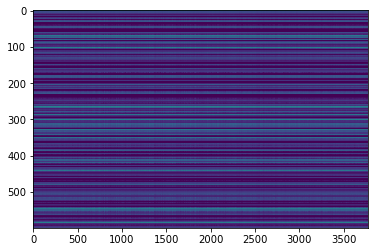

,AUC,pAUC
Source_0,0.535500,0.505263
Source_1,0.749000,0.567368
Source_2,0.417300,0.476316
Target_0,0.426500,0.508947
Target_1,0.917300,0.815263
Target_2,0.199100,0.473684
mean,0.540783,0.557807
h_mean,0.426855,0.538421


2021-05-24 12:18:49,774 - pytorch_modeler.py - INFO - epoch:1/100, train_losses:24383.424316, val_AUC_hmean:0.426855, val_pAUC_hmean:0.538421, best_flag:True
2021-05-24 12:18:49,775 - pytorch_modeler.py - INFO - train
100%|██████████| 12/12 [00:00<00:00, 22.96it/s]
2021-05-24 12:18:50,301 - pytorch_modeler.py - INFO - valid_source
100%|██████████| 2/2 [00:00<00:00, 10.10it/s]
2021-05-24 12:18:50,532 - pytorch_modeler.py - INFO - valid_target
  0%|          | 0/2 [00:00<?, ?it/s]

reconst: 6108.0244140625, KLd: 7.034420967102051, center_loss: 122.01664733886719


100%|██████████| 2/2 [00:00<00:00, 11.50it/s]


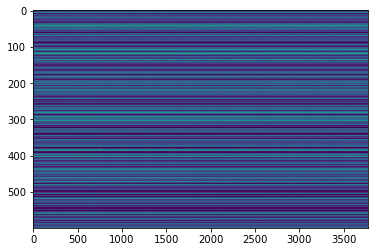

,AUC,pAUC
Source_0,0.556900,0.569474
Source_1,0.797400,0.671579
Source_2,0.476600,0.516316
Target_0,0.395700,0.502632
Target_1,0.946500,0.897895
Target_2,0.196900,0.474211
mean,0.561667,0.605351
h_mean,0.434457,0.577265


2021-05-24 12:18:51,772 - pytorch_modeler.py - INFO - epoch:2/100, train_losses:17403.906087, val_AUC_hmean:0.434457, val_pAUC_hmean:0.577265, best_flag:True
2021-05-24 12:18:51,773 - pytorch_modeler.py - INFO - train
100%|██████████| 12/12 [00:00<00:00, 23.56it/s]
2021-05-24 12:18:52,285 - pytorch_modeler.py - INFO - valid_source
100%|██████████| 2/2 [00:00<00:00, 11.12it/s]
2021-05-24 12:18:52,487 - pytorch_modeler.py - INFO - valid_target
  0%|          | 0/2 [00:00<?, ?it/s]

reconst: 5611.94921875, KLd: 3.9088430404663086, center_loss: 112.15806579589844


100%|██████████| 2/2 [00:00<00:00, 11.42it/s]


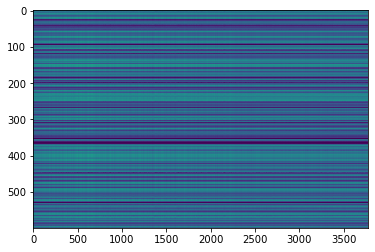

,AUC,pAUC
Source_0,0.594800,0.566842
Source_1,0.811100,0.710000
Source_2,0.468800,0.571053
Target_0,0.347600,0.505789
Target_1,0.941100,0.871579
Target_2,0.234500,0.477895
mean,0.566317,0.617193
h_mean,0.452793,0.591674


2021-05-24 12:18:53,668 - pytorch_modeler.py - INFO - epoch:3/100, train_losses:16266.428711, val_AUC_hmean:0.452793, val_pAUC_hmean:0.591674, best_flag:True
2021-05-24 12:18:53,669 - pytorch_modeler.py - INFO - train
100%|██████████| 12/12 [00:00<00:00, 23.26it/s]
2021-05-24 12:18:54,187 - pytorch_modeler.py - INFO - valid_source
100%|██████████| 2/2 [00:00<00:00,  9.87it/s]
2021-05-24 12:18:54,413 - pytorch_modeler.py - INFO - valid_target
  0%|          | 0/2 [00:00<?, ?it/s]

reconst: 5507.03955078125, KLd: 2.539503812789917, center_loss: 110.08706665039062


100%|██████████| 2/2 [00:00<00:00, 11.68it/s]


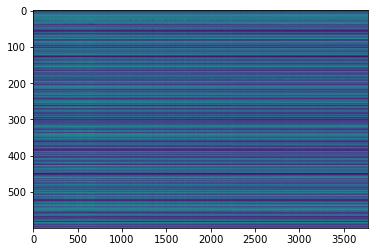

,AUC,pAUC
Source_0,0.616000,0.589474
Source_1,0.839600,0.690000
Source_2,0.592600,0.594211
Target_0,0.362900,0.514737
Target_1,0.941000,0.835263
Target_2,0.314800,0.476316
mean,0.611150,0.616667
h_mean,0.521884,0.595946


2021-05-24 12:18:55,668 - pytorch_modeler.py - INFO - epoch:4/100, train_losses:15608.378581, val_AUC_hmean:0.521884, val_pAUC_hmean:0.595946, best_flag:True
2021-05-24 12:18:55,669 - pytorch_modeler.py - INFO - train
100%|██████████| 12/12 [00:00<00:00, 20.54it/s]
2021-05-24 12:18:56,255 - pytorch_modeler.py - INFO - valid_source
100%|██████████| 2/2 [00:00<00:00, 11.68it/s]
2021-05-24 12:18:56,449 - pytorch_modeler.py - INFO - valid_target
  0%|          | 0/2 [00:00<?, ?it/s]

reconst: 5566.4814453125, KLd: 1.7583024501800537, center_loss: 111.29210662841797


100%|██████████| 2/2 [00:00<00:00, 11.84it/s]


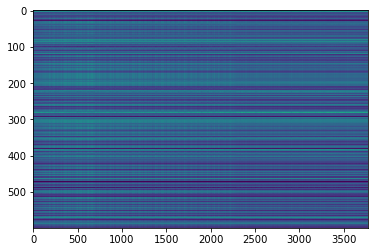

,AUC,pAUC
Source_0,0.696600,0.572632
Source_1,0.898200,0.770526
Source_2,0.526600,0.585263
Target_0,0.442600,0.521053
Target_1,0.959700,0.871579
Target_2,0.418400,0.475263
mean,0.657017,0.632719
h_mean,0.591758,0.604631


2021-05-24 12:18:57,690 - pytorch_modeler.py - INFO - epoch:5/100, train_losses:15010.436117, val_AUC_hmean:0.591758, val_pAUC_hmean:0.604631, best_flag:True
2021-05-24 12:18:57,691 - pytorch_modeler.py - INFO - train
100%|██████████| 12/12 [00:00<00:00, 22.61it/s]
2021-05-24 12:18:58,224 - pytorch_modeler.py - INFO - valid_source
100%|██████████| 2/2 [00:00<00:00, 10.85it/s]
2021-05-24 12:18:58,433 - pytorch_modeler.py - INFO - valid_target
  0%|          | 0/2 [00:00<?, ?it/s]

reconst: 5335.12109375, KLd: 1.4104719161987305, center_loss: 106.67173767089844


100%|██████████| 2/2 [00:00<00:00, 10.65it/s]
2021-05-24 12:18:58,647 - pytorch_modeler.py - INFO - epoch:6/100, train_losses:14544.788411, val_AUC_hmean:0.588658, val_pAUC_hmean:0.593800, best_flag:False
2021-05-24 12:18:58,648 - pytorch_modeler.py - INFO - train
100%|██████████| 12/12 [00:00<00:00, 23.25it/s]
2021-05-24 12:18:59,166 - pytorch_modeler.py - INFO - valid_source
100%|██████████| 2/2 [00:00<00:00, 11.37it/s]
2021-05-24 12:18:59,365 - pytorch_modeler.py - INFO - valid_target
  0%|          | 0/2 [00:00<?, ?it/s]

reconst: 5238.5078125, KLd: 1.1322169303894043, center_loss: 104.74557495117188


100%|██████████| 2/2 [00:00<00:00, 11.13it/s]
2021-05-24 12:18:59,570 - pytorch_modeler.py - INFO - epoch:7/100, train_losses:14182.849121, val_AUC_hmean:0.566579, val_pAUC_hmean:0.602639, best_flag:False
2021-05-24 12:18:59,571 - pytorch_modeler.py - INFO - train
100%|██████████| 12/12 [00:00<00:00, 22.93it/s]
2021-05-24 12:19:00,097 - pytorch_modeler.py - INFO - valid_source
100%|██████████| 2/2 [00:00<00:00, 11.50it/s]
2021-05-24 12:19:00,292 - pytorch_modeler.py - INFO - valid_target
  0%|          | 0/2 [00:00<?, ?it/s]

reconst: 5444.234375, KLd: 0.9090492129325867, center_loss: 108.86485290527344


100%|██████████| 2/2 [00:00<00:00, 10.26it/s]


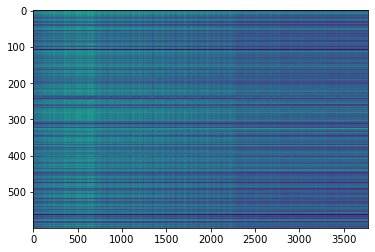

,AUC,pAUC
Source_0,0.743200,0.553158
Source_1,0.915500,0.802632
Source_2,0.526100,0.576316
Target_0,0.473900,0.518947
Target_1,0.967400,0.894211
Target_2,0.551600,0.483158
mean,0.696283,0.638070
h_mean,0.645483,0.605824


2021-05-24 12:19:01,524 - pytorch_modeler.py - INFO - epoch:8/100, train_losses:13754.507243, val_AUC_hmean:0.645483, val_pAUC_hmean:0.605824, best_flag:True
2021-05-24 12:19:01,525 - pytorch_modeler.py - INFO - train
100%|██████████| 12/12 [00:00<00:00, 21.85it/s]
2021-05-24 12:19:02,077 - pytorch_modeler.py - INFO - valid_source
100%|██████████| 2/2 [00:00<00:00, 11.15it/s]
2021-05-24 12:19:02,280 - pytorch_modeler.py - INFO - valid_target
  0%|          | 0/2 [00:00<?, ?it/s]

reconst: 5016.12890625, KLd: 1.0199105739593506, center_loss: 100.3006591796875


100%|██████████| 2/2 [00:00<00:00, 10.98it/s]
2021-05-24 12:19:02,490 - pytorch_modeler.py - INFO - epoch:9/100, train_losses:13470.188070, val_AUC_hmean:0.634313, val_pAUC_hmean:0.587558, best_flag:False
2021-05-24 12:19:02,491 - pytorch_modeler.py - INFO - train
100%|██████████| 12/12 [00:00<00:00, 22.89it/s]
2021-05-24 12:19:03,018 - pytorch_modeler.py - INFO - valid_source
100%|██████████| 2/2 [00:00<00:00, 10.75it/s]
2021-05-24 12:19:03,230 - pytorch_modeler.py - INFO - valid_target
  0%|          | 0/2 [00:00<?, ?it/s]

reconst: 5055.9912109375, KLd: 0.8261919021606445, center_loss: 101.10195922851562


100%|██████████| 2/2 [00:00<00:00, 10.74it/s]
2021-05-24 12:19:03,442 - pytorch_modeler.py - INFO - epoch:10/100, train_losses:13131.480713, val_AUC_hmean:0.663118, val_pAUC_hmean:0.605571, best_flag:False
2021-05-24 12:19:03,444 - pytorch_modeler.py - INFO - train
100%|██████████| 12/12 [00:00<00:00, 22.94it/s]
2021-05-24 12:19:03,969 - pytorch_modeler.py - INFO - valid_source
100%|██████████| 2/2 [00:00<00:00, 11.43it/s]
2021-05-24 12:19:04,166 - pytorch_modeler.py - INFO - valid_target
  0%|          | 0/2 [00:00<?, ?it/s]

reconst: 6066.4306640625, KLd: 0.7509006261825562, center_loss: 121.31214904785156


100%|██████████| 2/2 [00:00<00:00, 11.18it/s]


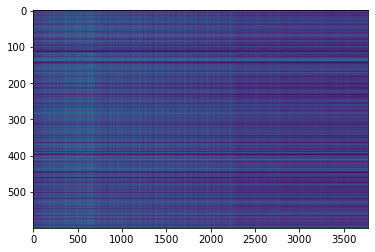

,AUC,pAUC
Source_0,0.562500,0.573684
Source_1,0.912700,0.782105
Source_2,0.515700,0.552105
Target_0,0.637800,0.543684
Target_1,0.955100,0.854737
Target_2,0.914200,0.798421
mean,0.749667,0.684123
h_mean,0.704119,0.659725


2021-05-24 12:19:05,363 - pytorch_modeler.py - INFO - epoch:11/100, train_losses:12776.746989, val_AUC_hmean:0.704119, val_pAUC_hmean:0.659725, best_flag:True
2021-05-24 12:19:05,364 - pytorch_modeler.py - INFO - train
100%|██████████| 12/12 [00:00<00:00, 23.26it/s]
2021-05-24 12:19:05,882 - pytorch_modeler.py - INFO - valid_source
100%|██████████| 2/2 [00:00<00:00, 11.56it/s]
2021-05-24 12:19:06,077 - pytorch_modeler.py - INFO - valid_target
  0%|          | 0/2 [00:00<?, ?it/s]

reconst: 4918.14013671875, KLd: 0.650467038154602, center_loss: 98.34872436523438


100%|██████████| 2/2 [00:00<00:00, 11.12it/s]
2021-05-24 12:19:06,281 - pytorch_modeler.py - INFO - epoch:12/100, train_losses:12474.837321, val_AUC_hmean:0.651346, val_pAUC_hmean:0.609347, best_flag:False
2021-05-24 12:19:06,282 - pytorch_modeler.py - INFO - train
100%|██████████| 12/12 [00:00<00:00, 23.05it/s]
2021-05-24 12:19:06,805 - pytorch_modeler.py - INFO - valid_source
100%|██████████| 2/2 [00:00<00:00, 11.44it/s]
2021-05-24 12:19:07,002 - pytorch_modeler.py - INFO - valid_target
  0%|          | 0/2 [00:00<?, ?it/s]

reconst: 4819.43798828125, KLd: 0.650946855545044, center_loss: 96.37443542480469


100%|██████████| 2/2 [00:00<00:00, 11.74it/s]
2021-05-24 12:19:07,196 - pytorch_modeler.py - INFO - epoch:13/100, train_losses:12212.693115, val_AUC_hmean:0.645986, val_pAUC_hmean:0.598482, best_flag:False
2021-05-24 12:19:07,197 - pytorch_modeler.py - INFO - train
100%|██████████| 12/12 [00:00<00:00, 21.64it/s]
2021-05-24 12:19:07,754 - pytorch_modeler.py - INFO - valid_source
100%|██████████| 2/2 [00:00<00:00, 10.87it/s]
2021-05-24 12:19:07,961 - pytorch_modeler.py - INFO - valid_target
  0%|          | 0/2 [00:00<?, ?it/s]

reconst: 4402.25341796875, KLd: 1.052965760231018, center_loss: 88.02302551269531


100%|██████████| 2/2 [00:00<00:00, 11.44it/s]
2021-05-24 12:19:08,164 - pytorch_modeler.py - INFO - epoch:14/100, train_losses:12003.546468, val_AUC_hmean:0.587059, val_pAUC_hmean:0.598293, best_flag:False
2021-05-24 12:19:08,165 - pytorch_modeler.py - INFO - train
100%|██████████| 12/12 [00:00<00:00, 22.15it/s]
2021-05-24 12:19:08,709 - pytorch_modeler.py - INFO - valid_source
100%|██████████| 2/2 [00:00<00:00, 11.20it/s]
2021-05-24 12:19:08,909 - pytorch_modeler.py - INFO - valid_target
  0%|          | 0/2 [00:00<?, ?it/s]

reconst: 4334.33642578125, KLd: 1.4731180667877197, center_loss: 86.65646362304688


100%|██████████| 2/2 [00:00<00:00, 11.19it/s]
2021-05-24 12:19:09,112 - pytorch_modeler.py - INFO - epoch:15/100, train_losses:11936.889486, val_AUC_hmean:0.490580, val_pAUC_hmean:0.591980, best_flag:False
2021-05-24 12:19:09,113 - pytorch_modeler.py - INFO - train
100%|██████████| 12/12 [00:00<00:00, 23.39it/s]
2021-05-24 12:19:09,628 - pytorch_modeler.py - INFO - valid_source
100%|██████████| 2/2 [00:00<00:00, 11.35it/s]
2021-05-24 12:19:09,826 - pytorch_modeler.py - INFO - valid_target
  0%|          | 0/2 [00:00<?, ?it/s]

reconst: 4400.88427734375, KLd: 1.1099004745483398, center_loss: 87.99468994140625


100%|██████████| 2/2 [00:00<00:00, 11.28it/s]
2021-05-24 12:19:10,028 - pytorch_modeler.py - INFO - epoch:16/100, train_losses:11640.687826, val_AUC_hmean:0.599750, val_pAUC_hmean:0.588586, best_flag:False
2021-05-24 12:19:10,030 - pytorch_modeler.py - INFO - train
100%|██████████| 12/12 [00:00<00:00, 23.35it/s]
2021-05-24 12:19:10,546 - pytorch_modeler.py - INFO - valid_source
100%|██████████| 2/2 [00:00<00:00, 10.79it/s]
2021-05-24 12:19:10,753 - pytorch_modeler.py - INFO - valid_target
  0%|          | 0/2 [00:00<?, ?it/s]

reconst: 4705.9560546875, KLd: 0.9978938102722168, center_loss: 94.09843444824219


100%|██████████| 2/2 [00:00<00:00, 11.62it/s]
2021-05-24 12:19:10,952 - pytorch_modeler.py - INFO - epoch:17/100, train_losses:11362.808350, val_AUC_hmean:0.623169, val_pAUC_hmean:0.601249, best_flag:False
2021-05-24 12:19:10,953 - pytorch_modeler.py - INFO - train
100%|██████████| 12/12 [00:00<00:00, 23.37it/s]
2021-05-24 12:19:11,469 - pytorch_modeler.py - INFO - valid_source
100%|██████████| 2/2 [00:00<00:00, 11.46it/s]
2021-05-24 12:19:11,665 - pytorch_modeler.py - INFO - valid_target
  0%|          | 0/2 [00:00<?, ?it/s]

reconst: 4489.26171875, KLd: 1.0239886045455933, center_loss: 89.76399230957031


100%|██████████| 2/2 [00:00<00:00, 11.16it/s]
2021-05-24 12:19:11,870 - pytorch_modeler.py - INFO - epoch:18/100, train_losses:11139.001628, val_AUC_hmean:0.636466, val_pAUC_hmean:0.586902, best_flag:False
2021-05-24 12:19:11,872 - pytorch_modeler.py - INFO - train
100%|██████████| 12/12 [00:00<00:00, 23.50it/s]
2021-05-24 12:19:12,385 - pytorch_modeler.py - INFO - valid_source
100%|██████████| 2/2 [00:00<00:00, 11.13it/s]
2021-05-24 12:19:12,586 - pytorch_modeler.py - INFO - valid_target
  0%|          | 0/2 [00:00<?, ?it/s]

reconst: 4059.41552734375, KLd: 0.7722650766372681, center_loss: 81.17213439941406


100%|██████████| 2/2 [00:00<00:00, 11.24it/s]
2021-05-24 12:19:12,791 - pytorch_modeler.py - INFO - epoch:19/100, train_losses:10833.697673, val_AUC_hmean:0.595189, val_pAUC_hmean:0.596007, best_flag:False
2021-05-24 12:19:12,792 - pytorch_modeler.py - INFO - train
100%|██████████| 12/12 [00:00<00:00, 23.20it/s]
2021-05-24 12:19:13,311 - pytorch_modeler.py - INFO - valid_source
100%|██████████| 2/2 [00:00<00:00, 11.56it/s]
2021-05-24 12:19:13,507 - pytorch_modeler.py - INFO - valid_target
  0%|          | 0/2 [00:00<?, ?it/s]

reconst: 4270.47607421875, KLd: 0.7499614953994751, center_loss: 85.39382934570312


100%|██████████| 2/2 [00:00<00:00, 11.56it/s]
2021-05-24 12:19:13,708 - pytorch_modeler.py - INFO - epoch:20/100, train_losses:10622.638916, val_AUC_hmean:0.531709, val_pAUC_hmean:0.585203, best_flag:False
2021-05-24 12:19:13,709 - pytorch_modeler.py - INFO - train
100%|██████████| 12/12 [00:00<00:00, 23.00it/s]
2021-05-24 12:19:14,233 - pytorch_modeler.py - INFO - valid_source
100%|██████████| 2/2 [00:00<00:00,  9.88it/s]
2021-05-24 12:19:14,457 - pytorch_modeler.py - INFO - valid_target
  0%|          | 0/2 [00:00<?, ?it/s]

reconst: 3980.9462890625, KLd: 0.6738325953483582, center_loss: 79.604736328125


100%|██████████| 2/2 [00:00<00:00, 11.59it/s]
2021-05-24 12:19:14,655 - pytorch_modeler.py - INFO - epoch:21/100, train_losses:10428.758626, val_AUC_hmean:0.626780, val_pAUC_hmean:0.592042, best_flag:False
2021-05-24 12:19:14,656 - pytorch_modeler.py - INFO - train
100%|██████████| 12/12 [00:00<00:00, 23.09it/s]
2021-05-24 12:19:15,179 - pytorch_modeler.py - INFO - valid_source
100%|██████████| 2/2 [00:00<00:00, 10.73it/s]
2021-05-24 12:19:15,387 - pytorch_modeler.py - INFO - valid_target
  0%|          | 0/2 [00:00<?, ?it/s]

reconst: 3977.84619140625, KLd: 0.7101006507873535, center_loss: 79.54205322265625


100%|██████████| 2/2 [00:00<00:00, 10.67it/s]
2021-05-24 12:19:15,602 - pytorch_modeler.py - INFO - epoch:22/100, train_losses:10113.252116, val_AUC_hmean:0.572289, val_pAUC_hmean:0.587135, best_flag:False
2021-05-24 12:19:15,604 - pytorch_modeler.py - INFO - train
100%|██████████| 12/12 [00:00<00:00, 23.13it/s]
2021-05-24 12:19:16,125 - pytorch_modeler.py - INFO - valid_source
100%|██████████| 2/2 [00:00<00:00, 10.37it/s]
2021-05-24 12:19:16,340 - pytorch_modeler.py - INFO - valid_target
  0%|          | 0/2 [00:00<?, ?it/s]

reconst: 4163.7041015625, KLd: 0.6277252435684204, center_loss: 83.26083374023438


100%|██████████| 2/2 [00:00<00:00, 11.38it/s]
2021-05-24 12:19:16,540 - pytorch_modeler.py - INFO - epoch:23/100, train_losses:9905.133464, val_AUC_hmean:0.593126, val_pAUC_hmean:0.583825, best_flag:False
2021-05-24 12:19:16,541 - pytorch_modeler.py - INFO - train
100%|██████████| 12/12 [00:00<00:00, 23.63it/s]
2021-05-24 12:19:17,051 - pytorch_modeler.py - INFO - valid_source
100%|██████████| 2/2 [00:00<00:00, 11.29it/s]
2021-05-24 12:19:17,251 - pytorch_modeler.py - INFO - valid_target
  0%|          | 0/2 [00:00<?, ?it/s]

reconst: 3779.005859375, KLd: 0.6784467697143555, center_loss: 75.56588745117188


100%|██████████| 2/2 [00:00<00:00, 10.85it/s]
2021-05-24 12:19:17,460 - pytorch_modeler.py - INFO - epoch:24/100, train_losses:9716.092448, val_AUC_hmean:0.621108, val_pAUC_hmean:0.588444, best_flag:False
2021-05-24 12:19:17,461 - pytorch_modeler.py - INFO - train
100%|██████████| 12/12 [00:00<00:00, 23.24it/s]
2021-05-24 12:19:17,980 - pytorch_modeler.py - INFO - valid_source
100%|██████████| 2/2 [00:00<00:00, 11.08it/s]
2021-05-24 12:19:18,183 - pytorch_modeler.py - INFO - valid_target
  0%|          | 0/2 [00:00<?, ?it/s]

reconst: 3631.808349609375, KLd: 0.5835586190223694, center_loss: 72.62395477294922


100%|██████████| 2/2 [00:00<00:00, 11.29it/s]
2021-05-24 12:19:18,386 - pytorch_modeler.py - INFO - epoch:25/100, train_losses:9549.434977, val_AUC_hmean:0.591482, val_pAUC_hmean:0.590915, best_flag:False
2021-05-24 12:19:18,387 - pytorch_modeler.py - INFO - train
100%|██████████| 12/12 [00:00<00:00, 23.37it/s]
2021-05-24 12:19:18,903 - pytorch_modeler.py - INFO - valid_source
100%|██████████| 2/2 [00:00<00:00, 11.03it/s]
2021-05-24 12:19:19,109 - pytorch_modeler.py - INFO - valid_target
  0%|          | 0/2 [00:00<?, ?it/s]

reconst: 3538.87060546875, KLd: 0.5316834449768066, center_loss: 70.7661361694336


100%|██████████| 2/2 [00:00<00:00, 10.33it/s]
2021-05-24 12:19:19,330 - pytorch_modeler.py - INFO - epoch:26/100, train_losses:9366.252279, val_AUC_hmean:0.528593, val_pAUC_hmean:0.589706, best_flag:False
2021-05-24 12:19:19,332 - pytorch_modeler.py - INFO - train
100%|██████████| 12/12 [00:00<00:00, 22.94it/s]
2021-05-24 12:19:19,857 - pytorch_modeler.py - INFO - valid_source
100%|██████████| 2/2 [00:00<00:00, 10.42it/s]
2021-05-24 12:19:20,077 - pytorch_modeler.py - INFO - valid_target
  0%|          | 0/2 [00:00<?, ?it/s]

reconst: 3414.771484375, KLd: 0.460916668176651, center_loss: 68.28564453125


100%|██████████| 2/2 [00:00<00:00, 10.78it/s]
2021-05-24 12:19:20,289 - pytorch_modeler.py - INFO - epoch:27/100, train_losses:9150.601562, val_AUC_hmean:0.507163, val_pAUC_hmean:0.586941, best_flag:False
2021-05-24 12:19:20,291 - pytorch_modeler.py - INFO - train
100%|██████████| 12/12 [00:00<00:00, 22.44it/s]
2021-05-24 12:19:20,828 - pytorch_modeler.py - INFO - valid_source
100%|██████████| 2/2 [00:00<00:00,  9.83it/s]
2021-05-24 12:19:21,059 - pytorch_modeler.py - INFO - valid_target
  0%|          | 0/2 [00:00<?, ?it/s]

reconst: 3432.7763671875, KLd: 0.49953705072402954, center_loss: 68.64502716064453


100%|██████████| 2/2 [00:00<00:00,  9.90it/s]
2021-05-24 12:19:21,288 - pytorch_modeler.py - INFO - epoch:28/100, train_losses:8975.017334, val_AUC_hmean:0.575402, val_pAUC_hmean:0.573720, best_flag:False
2021-05-24 12:19:21,289 - pytorch_modeler.py - INFO - train
100%|██████████| 12/12 [00:00<00:00, 21.29it/s]
2021-05-24 12:19:21,856 - pytorch_modeler.py - INFO - valid_source
100%|██████████| 2/2 [00:00<00:00, 11.10it/s]
2021-05-24 12:19:22,062 - pytorch_modeler.py - INFO - valid_target
  0%|          | 0/2 [00:00<?, ?it/s]

reconst: 3394.2548828125, KLd: 0.5782487392425537, center_loss: 67.8730239868164


100%|██████████| 2/2 [00:00<00:00, 11.14it/s]
2021-05-24 12:19:22,266 - pytorch_modeler.py - INFO - epoch:29/100, train_losses:8859.306071, val_AUC_hmean:0.449079, val_pAUC_hmean:0.565958, best_flag:False
2021-05-24 12:19:22,268 - pytorch_modeler.py - INFO - train
100%|██████████| 12/12 [00:00<00:00, 22.52it/s]
2021-05-24 12:19:22,803 - pytorch_modeler.py - INFO - valid_source
100%|██████████| 2/2 [00:00<00:00, 11.31it/s]
2021-05-24 12:19:23,002 - pytorch_modeler.py - INFO - valid_target
  0%|          | 0/2 [00:00<?, ?it/s]

reconst: 3338.5283203125, KLd: 0.6130311489105225, center_loss: 66.75779724121094


100%|██████████| 2/2 [00:00<00:00, 10.74it/s]
2021-05-24 12:19:23,218 - pytorch_modeler.py - INFO - epoch:30/100, train_losses:8698.697428, val_AUC_hmean:0.573099, val_pAUC_hmean:0.588612, best_flag:False
2021-05-24 12:19:23,220 - pytorch_modeler.py - INFO - train
100%|██████████| 12/12 [00:00<00:00, 21.28it/s]
2021-05-24 12:19:23,786 - pytorch_modeler.py - INFO - valid_source
100%|██████████| 2/2 [00:00<00:00, 10.96it/s]
2021-05-24 12:19:23,990 - pytorch_modeler.py - INFO - valid_target
  0%|          | 0/2 [00:00<?, ?it/s]

reconst: 3241.379150390625, KLd: 0.5606324672698975, center_loss: 64.81584167480469


100%|██████████| 2/2 [00:00<00:00, 11.50it/s]
2021-05-24 12:19:24,189 - pytorch_modeler.py - INFO - epoch:31/100, train_losses:8494.528890, val_AUC_hmean:0.534985, val_pAUC_hmean:0.576644, best_flag:False
2021-05-24 12:19:24,191 - pytorch_modeler.py - INFO - train
100%|██████████| 12/12 [00:00<00:00, 22.25it/s]
2021-05-24 12:19:24,733 - pytorch_modeler.py - INFO - valid_source
100%|██████████| 2/2 [00:00<00:00, 11.45it/s]
2021-05-24 12:19:24,932 - pytorch_modeler.py - INFO - valid_target
  0%|          | 0/2 [00:00<?, ?it/s]

reconst: 3502.197998046875, KLd: 0.5055663585662842, center_loss: 70.03340148925781


100%|██████████| 2/2 [00:00<00:00, 11.31it/s]
2021-05-24 12:19:25,138 - pytorch_modeler.py - INFO - epoch:32/100, train_losses:8331.851318, val_AUC_hmean:0.571277, val_pAUC_hmean:0.575266, best_flag:False
2021-05-24 12:19:25,140 - pytorch_modeler.py - INFO - train
100%|██████████| 12/12 [00:00<00:00, 23.20it/s]
2021-05-24 12:19:25,661 - pytorch_modeler.py - INFO - valid_source
100%|██████████| 2/2 [00:00<00:00, 11.14it/s]
2021-05-24 12:19:25,863 - pytorch_modeler.py - INFO - valid_target
  0%|          | 0/2 [00:00<?, ?it/s]

reconst: 3287.967529296875, KLd: 0.5807048082351685, center_loss: 65.74720764160156


100%|██████████| 2/2 [00:00<00:00, 10.90it/s]
2021-05-24 12:19:26,079 - pytorch_modeler.py - INFO - epoch:33/100, train_losses:8218.935994, val_AUC_hmean:0.524023, val_pAUC_hmean:0.589249, best_flag:False
2021-05-24 12:19:26,080 - pytorch_modeler.py - INFO - train
100%|██████████| 12/12 [00:00<00:00, 23.33it/s]
2021-05-24 12:19:26,597 - pytorch_modeler.py - INFO - valid_source
100%|██████████| 2/2 [00:00<00:00, 11.32it/s]
2021-05-24 12:19:26,795 - pytorch_modeler.py - INFO - valid_target
  0%|          | 0/2 [00:00<?, ?it/s]

reconst: 3399.48681640625, KLd: 0.622109055519104, center_loss: 67.9768295288086


100%|██████████| 2/2 [00:00<00:00, 10.14it/s]
2021-05-24 12:19:27,024 - pytorch_modeler.py - INFO - epoch:34/100, train_losses:8136.488363, val_AUC_hmean:0.595790, val_pAUC_hmean:0.585462, best_flag:False
2021-05-24 12:19:27,026 - pytorch_modeler.py - INFO - train
100%|██████████| 12/12 [00:00<00:00, 22.64it/s]
2021-05-24 12:19:27,559 - pytorch_modeler.py - INFO - valid_source
100%|██████████| 2/2 [00:00<00:00, 11.53it/s]
2021-05-24 12:19:27,753 - pytorch_modeler.py - INFO - valid_target
  0%|          | 0/2 [00:00<?, ?it/s]

reconst: 3269.78759765625, KLd: 0.6636381149291992, center_loss: 65.38203430175781


100%|██████████| 2/2 [00:00<00:00, 10.54it/s]
2021-05-24 12:19:27,968 - pytorch_modeler.py - INFO - epoch:35/100, train_losses:7977.956950, val_AUC_hmean:0.506512, val_pAUC_hmean:0.566716, best_flag:False
2021-05-24 12:19:27,969 - pytorch_modeler.py - INFO - train
100%|██████████| 12/12 [00:00<00:00, 23.46it/s]
2021-05-24 12:19:28,483 - pytorch_modeler.py - INFO - valid_source
100%|██████████| 2/2 [00:00<00:00, 10.53it/s]
2021-05-24 12:19:28,696 - pytorch_modeler.py - INFO - valid_target
  0%|          | 0/2 [00:00<?, ?it/s]

reconst: 3416.052734375, KLd: 0.5088258385658264, center_loss: 68.31043243408203


100%|██████████| 2/2 [00:00<00:00, 10.52it/s]
2021-05-24 12:19:28,917 - pytorch_modeler.py - INFO - epoch:36/100, train_losses:7767.166260, val_AUC_hmean:0.569416, val_pAUC_hmean:0.588027, best_flag:False
2021-05-24 12:19:28,918 - pytorch_modeler.py - INFO - train
100%|██████████| 12/12 [00:00<00:00, 22.79it/s]
2021-05-24 12:19:29,447 - pytorch_modeler.py - INFO - valid_source
100%|██████████| 2/2 [00:00<00:00, 10.87it/s]
2021-05-24 12:19:29,654 - pytorch_modeler.py - INFO - valid_target
  0%|          | 0/2 [00:00<?, ?it/s]

reconst: 3177.185302734375, KLd: 0.4862730801105499, center_loss: 63.53349304199219


100%|██████████| 2/2 [00:00<00:00, 10.69it/s]
2021-05-24 12:19:29,867 - pytorch_modeler.py - INFO - epoch:37/100, train_losses:7620.994059, val_AUC_hmean:0.539891, val_pAUC_hmean:0.580399, best_flag:False
2021-05-24 12:19:29,868 - pytorch_modeler.py - INFO - train
100%|██████████| 12/12 [00:00<00:00, 23.39it/s]
2021-05-24 12:19:30,383 - pytorch_modeler.py - INFO - valid_source
100%|██████████| 2/2 [00:00<00:00, 11.10it/s]
2021-05-24 12:19:30,584 - pytorch_modeler.py - INFO - valid_target
  0%|          | 0/2 [00:00<?, ?it/s]

reconst: 3247.4677734375, KLd: 0.4136054515838623, center_loss: 64.94058990478516


100%|██████████| 2/2 [00:00<00:00, 11.65it/s]
2021-05-24 12:19:30,782 - pytorch_modeler.py - INFO - epoch:38/100, train_losses:7440.653687, val_AUC_hmean:0.623063, val_pAUC_hmean:0.583469, best_flag:False
2021-05-24 12:19:30,784 - pytorch_modeler.py - INFO - train
100%|██████████| 12/12 [00:00<00:00, 23.49it/s]
2021-05-24 12:19:31,297 - pytorch_modeler.py - INFO - valid_source
100%|██████████| 2/2 [00:00<00:00, 11.65it/s]
2021-05-24 12:19:31,491 - pytorch_modeler.py - INFO - valid_target
  0%|          | 0/2 [00:00<?, ?it/s]

reconst: 2954.369140625, KLd: 0.4504985809326172, center_loss: 59.07789611816406


100%|██████████| 2/2 [00:00<00:00, 11.04it/s]
2021-05-24 12:19:31,696 - pytorch_modeler.py - INFO - epoch:39/100, train_losses:7324.358154, val_AUC_hmean:0.570969, val_pAUC_hmean:0.576756, best_flag:False
2021-05-24 12:19:31,698 - pytorch_modeler.py - INFO - train
100%|██████████| 12/12 [00:00<00:00, 23.24it/s]
2021-05-24 12:19:32,216 - pytorch_modeler.py - INFO - valid_source
100%|██████████| 2/2 [00:00<00:00, 11.55it/s]
2021-05-24 12:19:32,411 - pytorch_modeler.py - INFO - valid_target
  0%|          | 0/2 [00:00<?, ?it/s]

reconst: 3061.31982421875, KLd: 0.5237994194030762, center_loss: 61.21538543701172


100%|██████████| 2/2 [00:00<00:00, 11.76it/s]
2021-05-24 12:19:32,606 - pytorch_modeler.py - INFO - epoch:40/100, train_losses:7174.671305, val_AUC_hmean:0.603905, val_pAUC_hmean:0.546161, best_flag:False
2021-05-24 12:19:32,607 - pytorch_modeler.py - INFO - train
100%|██████████| 12/12 [00:00<00:00, 22.93it/s]
2021-05-24 12:19:33,133 - pytorch_modeler.py - INFO - valid_source
100%|██████████| 2/2 [00:00<00:00, 10.81it/s]
2021-05-24 12:19:33,340 - pytorch_modeler.py - INFO - valid_target
  0%|          | 0/2 [00:00<?, ?it/s]

reconst: 2754.328369140625, KLd: 0.5587882399559021, center_loss: 55.074867248535156


100%|██████████| 2/2 [00:00<00:00, 10.80it/s]
2021-05-24 12:19:33,551 - pytorch_modeler.py - INFO - epoch:41/100, train_losses:7040.387492, val_AUC_hmean:0.518585, val_pAUC_hmean:0.563125, best_flag:False
2021-05-24 12:19:33,552 - pytorch_modeler.py - INFO - train
100%|██████████| 12/12 [00:00<00:00, 23.54it/s]
2021-05-24 12:19:34,064 - pytorch_modeler.py - INFO - valid_source
100%|██████████| 2/2 [00:00<00:00, 10.49it/s]
2021-05-24 12:19:34,283 - pytorch_modeler.py - INFO - valid_target
  0%|          | 0/2 [00:00<?, ?it/s]

reconst: 3083.05908203125, KLd: 0.49004000425338745, center_loss: 61.65092086791992


100%|██████████| 2/2 [00:00<00:00,  9.61it/s]
2021-05-24 12:19:34,519 - pytorch_modeler.py - INFO - epoch:42/100, train_losses:6927.863566, val_AUC_hmean:0.532307, val_pAUC_hmean:0.581377, best_flag:False
2021-05-24 12:19:34,520 - pytorch_modeler.py - INFO - train
100%|██████████| 12/12 [00:00<00:00, 20.83it/s]
2021-05-24 12:19:35,099 - pytorch_modeler.py - INFO - valid_source
100%|██████████| 2/2 [00:00<00:00, 11.51it/s]
2021-05-24 12:19:35,294 - pytorch_modeler.py - INFO - valid_target
  0%|          | 0/2 [00:00<?, ?it/s]

reconst: 2753.082763671875, KLd: 0.5721340179443359, center_loss: 55.04976272583008


100%|██████████| 2/2 [00:00<00:00, 11.63it/s]
2021-05-24 12:19:35,495 - pytorch_modeler.py - INFO - epoch:43/100, train_losses:6809.377279, val_AUC_hmean:0.527271, val_pAUC_hmean:0.566992, best_flag:False
2021-05-24 12:19:35,496 - pytorch_modeler.py - INFO - train
100%|██████████| 12/12 [00:00<00:00, 21.45it/s]
2021-05-24 12:19:36,059 - pytorch_modeler.py - INFO - valid_source
100%|██████████| 2/2 [00:00<00:00, 10.96it/s]
2021-05-24 12:19:36,264 - pytorch_modeler.py - INFO - valid_target
  0%|          | 0/2 [00:00<?, ?it/s]

reconst: 2630.826171875, KLd: 0.4174276888370514, center_loss: 52.60771179199219


100%|██████████| 2/2 [00:00<00:00, 11.26it/s]
2021-05-24 12:19:36,466 - pytorch_modeler.py - INFO - epoch:44/100, train_losses:6689.548950, val_AUC_hmean:0.513357, val_pAUC_hmean:0.577240, best_flag:False
2021-05-24 12:19:36,467 - pytorch_modeler.py - INFO - train
100%|██████████| 12/12 [00:00<00:00, 22.99it/s]
2021-05-24 12:19:36,991 - pytorch_modeler.py - INFO - valid_source
100%|██████████| 2/2 [00:00<00:00, 11.21it/s]
2021-05-24 12:19:37,193 - pytorch_modeler.py - INFO - valid_target
  0%|          | 0/2 [00:00<?, ?it/s]

reconst: 2848.853515625, KLd: 0.35600435733795166, center_loss: 56.969520568847656


100%|██████████| 2/2 [00:00<00:00, 11.33it/s]
2021-05-24 12:19:37,397 - pytorch_modeler.py - INFO - epoch:45/100, train_losses:6568.290527, val_AUC_hmean:0.539525, val_pAUC_hmean:0.573862, best_flag:False
2021-05-24 12:19:37,398 - pytorch_modeler.py - INFO - train
100%|██████████| 12/12 [00:00<00:00, 22.63it/s]
2021-05-24 12:19:37,930 - pytorch_modeler.py - INFO - valid_source
100%|██████████| 2/2 [00:00<00:00, 10.84it/s]
2021-05-24 12:19:38,142 - pytorch_modeler.py - INFO - valid_target
  0%|          | 0/2 [00:00<?, ?it/s]

reconst: 2645.839111328125, KLd: 0.40096810460090637, center_loss: 52.90839385986328


100%|██████████| 2/2 [00:00<00:00, 10.97it/s]
2021-05-24 12:19:38,351 - pytorch_modeler.py - INFO - epoch:46/100, train_losses:6464.028931, val_AUC_hmean:0.456613, val_pAUC_hmean:0.558105, best_flag:False
2021-05-24 12:19:38,352 - pytorch_modeler.py - INFO - train
100%|██████████| 12/12 [00:00<00:00, 22.70it/s]
2021-05-24 12:19:38,884 - pytorch_modeler.py - INFO - valid_source
100%|██████████| 2/2 [00:00<00:00, 10.88it/s]
2021-05-24 12:19:39,092 - pytorch_modeler.py - INFO - valid_target
  0%|          | 0/2 [00:00<?, ?it/s]

reconst: 2695.427734375, KLd: 0.41562893986701965, center_loss: 53.899749755859375


100%|██████████| 2/2 [00:00<00:00, 10.84it/s]
2021-05-24 12:19:39,302 - pytorch_modeler.py - INFO - epoch:47/100, train_losses:6436.431519, val_AUC_hmean:0.625869, val_pAUC_hmean:0.581044, best_flag:False
2021-05-24 12:19:39,303 - pytorch_modeler.py - INFO - train
 17%|█▋        | 2/12 [00:00<00:01,  7.55it/s]


KeyboardInterrupt: 

In [13]:
run(machine_types[0])